# Module 3 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

## k Nearest Neighbors and Model Evaluation

In this programming assignment you will use k Nearest Neighbors (kNN) to build a "model" that will estimate the compressive strength of various types of concrete. This assignment has several objectives:

1. Implement the kNN algorithm with k=9. Remember...the data + distance function is the model in kNN. In addition to asserts that unit test your code, you should "test drive" the model, showing output that a non-technical person could interpret.

2. You are going to compare the kNN model above against the baseline model described in the course notes (the mean of the training set's target variable). You should use 10 fold cross validation and Mean Squared Error (MSE):

$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$

as the evaluation metric ("error"). Refer to the course notes for the format your output should take. Don't forget a discussion of the results.

3. use validation curves to tune a *hyperparameter* of the model. 
In this case, the hyperparameter is *k*, the number of neighbors. Don't forget a discussion of the results.

4. evaluate the *generalization error* of the new model.
Because you may have just created a new, better model, you need a sense of its generalization error, calculate that. Again, what would you like to see as output here? Refer to the course notes. Don't forget a discussion of the results. Did the new model do better than either model in Q2?

5. pick one of the "Choose Your Own Adventure" options.

Refer to the "course notes" for this module for most of this assignment.
Anytime you just need test/train split, use fold index 0 for the test set and the remainder as the training set.
Discuss any results.

## Load the Data

The function `parse_data` loads the data from the specified file and returns a List of Lists. The outer List is the data set and each element (List) is a specific observation. Each value of an observation is for a particular measurement. This is what we mean by "tidy" data.

The function also returns the *shuffled* data because the data might have been collected in a particular order that *might* bias training.

In [1]:
import random
from typing import List, Dict, Tuple, Callable

In [2]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [float(value) for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [3]:
data = parse_data("concrete_compressive_strength.csv")

In [4]:
data[0]

[540.0, 0.0, 0.0, 162.0, 2.5, 1055.0, 676.0, 28.0, 61.89]

In [5]:
len(data)

1030

There are 1,030 observations and each observation has 8 measurements. The data dictionary for this data set tells us the definitions of the individual variables (columns/indices):

| Index | Variable | Definition |
|-------|----------|------------|
| 0     | cement   | kg in a cubic meter mixture |
| 1     | slag     | kg in a cubic meter mixture |
| 2     | ash      | kg in a cubic meter mixture |
| 3     | water    | kg in a cubic meter mixture |
| 4     | superplasticizer | kg in a cubic meter mixture |
| 5     | coarse aggregate | kg in a cubic meter mixture |
| 6     | fine aggregate | kg in a cubic meter mixture |
| 7     | age | days |
| 8     | concrete compressive strength | MPa |

The target ("y") variable is a Index 8, concrete compressive strength in (Mega?) [Pascals](https://en.wikipedia.org/wiki/Pascal_(unit)).

## Train/Test Splits - n folds

With n fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. You pick n based on the size of your data set. If you have a small data set--100 observations--and you used n=10, each fold would only have 10 observations. That's probably too small. You want at least 30. At the other extreme, we generally don't use n > 10.

With 1,030 observations, n = 10 is fine so we will have 10 folds.
`create_folds` will take a list (xs) and split it into `n` equal folds with each fold containing one-tenth of the observations.

In [6]:
def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [7]:
folds = create_folds(data, 10)

In [8]:
len(folds)

10

We always use one of the n folds as a test set (and, sometimes, one of the folds as a *pruning* set but not for kNN), and the remaining folds as a training set.
We need a function that'll take our n folds and return the train and test sets:

In [9]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

We can test the function to give us a train and test datasets where the test set is the fold at index 0:

In [10]:
train, test = create_train_test(folds, 0)

In [11]:
len(train)

927

In [12]:
len(test)

103

## Answers

Answer the questions above in the space provided below, adding cells as you need to.
Put everything in the helper functions and document them.
Document everything (what you're doing and why).
If you're not sure what format the output should take, refer to the course notes and what they do for that particular topic/algorithm.

## Problem 1: kNN

Implement k Nearest Neighbors with k = 9.

In [13]:
from typing import List, Dict, Tuple
from math import sqrt
import matplotlib.pyplot as plt
from statistics import stdev

<a id="distance"></a>
### distance

`distance` calculates the Euclidian distance between `example` and `query` for every dimension. The formula for the Euclidian distance is: $$ d(a, b) = \sqrt{\sum_i ^n (a_i - b_i)^2}$$
for every dimension $i$ in the `example` and `query`. The distance is used as a measure of "nearness" for use in the `kNN` algorithm below. **Used by**: [kNN](#kNN)

* **example**: a list of features used as the reference point
* **query**: a list of features used as the query point

**returns** float: the Euclidian distance between `example` and `query`

In [14]:
def distance(example: List[float], query: List[float]) -> float:
    dist = 0
    for example_val, query_val in zip(example, query):
        dist += (example_val - query_val) ** 2
    return sqrt(dist)

In [15]:
# assertions/unit tests
x = [1, 1]
y = [2, 2]
actual_dist = distance(x, y)
assert actual_dist == sqrt(2)

x = [1, 2, 3, 4, 5]
y = [5, 4, 3, 2, 1]
actual_dist = distance(x, y)
assert actual_dist == sqrt(40)

x, y = [], []
actual_dist = distance(x, y)
assert actual_dist == 0

<a id="processing"></a>
### processing

`processing` takes a list of the nearest neighbors to a query point (`nearest`) and a number of features in each example, and computes the mean of the target values for each example in `nearest`. This function is one example of how a list of nearest-neighbors can be processed - for use in a regression problem, this `processing` function works well. However, for use in a classification problem, the function must be adapted to return the majority class label, or some other metric of the `target` for the closest `k` neighbors. **Used by**: [kNN](#kNN)

* **nearest**: a list of the k-nearest neighbors to process
* **num_features**: the number of features in each example

**returns** float: the mean value of the `target` variable from `nearest`.

In [16]:
def processing(nearest: List[Tuple[float, List[float]]], num_features: int) -> float:
    if nearest:
        yvals = [examples[1][num_features] for examples in nearest]
        return sum(yvals) / len(yvals)
    else: return 0

In [17]:
# assertions/unit tests
nearest = [(1, [1, 1, 1]), (2, [2, 2, 2]), (3, [3, 3, 3])]
actual_mean = processing(nearest, 2)
assert actual_mean == 2

assert processing([], 2) == 0

nearest = [(1, [1, 1, 1, 5]), (2, [2, 2, 2, 13]), (3, [3, 3, 3, 21])]
actual_mean = processing(nearest, 3)
assert actual_mean == 13

<a id="knn"></a>
### knn

`knn` is the k-Nearest-Neighbors algorithm, which takes a `dataset`, a `query` point, and a `k` value and finds the `k` nearest points to `query` in `dataset`. The algorithm then returns the mean value of the `y` measurement from those neighbors as a guess for what the `query` point's `y` value will be. This implementation is used to solve a regression problem; as mentioned above, the `processing` and `distance` functions can be changed to allow for this function to solve a classification problem, as well. 

`kNN` is a classic example of a lazy machine learning algorithm - this algorithm takes a training set of data and uses it as the model to predict the test data. In eager algorithms, the algorithm might take training data and augment the model/"learn" from the training data, before being applied to the test data. **Uses**: [distance](#distance), [processing](#processing).

* **dataset**: the set of examples over which to find the nearest neighbors to `query`
* **query**: the point to which the k-nearest neighbors are found
* **k**: the number of nearest-neighbors to process
* **num_features**: the number of features in each example of `dataset`

**returns** float: the mean value of the `target` variable in the k-nearest neighbors to `query`

In [18]:
def knn(dataset: List[List], query: List, k: int, num_features: int) -> float:
    distances = []
    for example in dataset:
        curr_distance = distance(example[:num_features], query[:num_features])
        distances.append((curr_distance, example))
    distances = sorted(distances)
    nearest = distances[:k]
    return processing(nearest, num_features)

In [19]:
# assertions/unit tests
dataset = [[0.23, 0.81, 0.18], [0.42, 0.78, 0.33], [0.64, 0.23, 0.14], [0.87, 0.19, 0.17], [0.76, 0.43, 0.32]]
query = [0.39, 0.63, 0]
estimate = knn(dataset, query, 3, 2)
assert abs(estimate - 0.276) < 0.01

query = [0.39, 0.63, 0] 
estimate = knn(dataset, query, 8, 2)
assert abs(estimate - 0.228) < 0.01

query = [0.23, 0.81, 0]
estimate = knn(dataset, query, 1, 2)
assert estimate == 0.18

### Examples

These are 10 example runs using `kNN` to find the nearest neighbors to query points. These query points were chosen from the provided dataset. The features of each query, as well as the actual target value and expected target value, are printed in each line. As we can see, there is a strong correlation between the expected and actual values - most values are within 5-10 of the actual target value, and only a few are further than that.

In [20]:
# print features / actual y / estimate y
test_data = parse_data("concrete_compressive_strength.csv")
queries = [[190, 190, 0, 228, 0, 932, 670, 90, 42.33],
          [304, 76, 0, 228, 0, 932, 670, 28, 47.81],
          [380, 0, 0, 228, 0, 932, 670, 90, 52.91],
          [139.6, 209.4, 0, 192, 0, 1047, 806.9, 90, 39.36],
          [342, 38, 0, 228, 0, 932, 670, 365, 56.14],
          [380, 95, 0, 228, 0, 932, 594, 90, 40.56],
          [475, 0, 0, 228, 0, 932, 594, 180, 42.62],
          [427.5, 47.5, 0, 228, 0, 932, 594, 180, 41.84],
          [139.6, 209.4, 0, 192, 0, 1047, 806.9, 28, 28.24],
          [139.6, 209.4, 0, 192, 0, 1047, 806.9, 3, 8.06]]

for query in queries:
    estimate = knn(test_data, query, 9, 8)
    print("Features:", query[:8], "Actual y:", query[8], "Estimated y:", estimate)

Features: [190, 190, 0, 228, 0, 932, 670, 90] Actual y: 42.33 Estimated y: 40.565555555555555
Features: [304, 76, 0, 228, 0, 932, 670, 28] Actual y: 47.81 Estimated y: 45.781111111111116
Features: [380, 0, 0, 228, 0, 932, 670, 90] Actual y: 52.91 Estimated y: 49.112222222222215
Features: [139.6, 209.4, 0, 192, 0, 1047, 806.9, 90] Actual y: 39.36 Estimated y: 26.584444444444443
Features: [342, 38, 0, 228, 0, 932, 670, 365] Actual y: 56.14 Estimated y: 51.885555555555555
Features: [380, 95, 0, 228, 0, 932, 594, 90] Actual y: 40.56 Estimated y: 38.97333333333333
Features: [475, 0, 0, 228, 0, 932, 594, 180] Actual y: 42.62 Estimated y: 44.46
Features: [427.5, 47.5, 0, 228, 0, 932, 594, 180] Actual y: 41.84 Estimated y: 42.97888888888889
Features: [139.6, 209.4, 0, 192, 0, 1047, 806.9, 28] Actual y: 28.24 Estimated y: 22.506666666666668
Features: [139.6, 209.4, 0, 192, 0, 1047, 806.9, 3] Actual y: 8.06 Estimated y: 21.774444444444445


## Problem 2: Evaluation vs. The Mean

Using Mean Squared Error (MSE) as your evaluation metric, evaluate your implement above and the Null model, the mean.

<a id="mse"></a>
### mse

`mse` takes in a list of `actuals` values and a list of `estimates` and computes the mean squared error from the two. The formula for mean squared error is: $$MSE = \frac1n \sum_i^n (y_i - \hat{y}_i)^2 $$
The $y_i$ represents the estimate value for the target variable, and $\hat{y}_i$ represents the actual target value. Mean squared error is a suitable evaluation metric for a regression model, and is therefore useful in determining whether our `kNN` model is performing well. 

* **actuals**: the list of actual target values
* **estimates**: the list of estimate target values (`kNN` or `Null` model)

**returns** float: the mean squared error

In [21]:
def mse(actuals: List[float], estimates: List[float]) -> float:
    mse = 0
    for yval, y_hat in zip(actuals, estimates):
        mse += ((yval - y_hat) ** 2)
    return mse / len(actuals) if actuals else 0

In [22]:
# assertions/unit tests
actuals = [1, 2, 3, 4, 5]
estimates = [2, 3, 4, 5, 6]
actual_mse = mse(actuals, estimates)
assert actual_mse == 1

actuals, estimates = [], []
actual_mse = mse(actuals, estimates)
assert actual_mse == 0

actuals, estimates = [1, 3, 5, 7], [0, 0, 0, 0]
actual_mse = mse(actuals, estimates)
assert actual_mse == (1 + 9 + 25 + 49) / 4

### MSE for Null and kNN

Below, we use 10-fold cross validation to compare the mean squared error for the Null model and the `kNN` model. By comparing the MSE values for `kNN` model to the `Null` model, which simply takes the average `target` value from the `train` set as the estimate for each `test` query, we can determine the strength of the `kNN` model. 

In 10-fold cross validation, we split our dataset into folds of equal size, and iteratively choose each fold to be the test set, with the remaining folds as the training set. For example, the first iteration for 10-fold cross validation chooses Fold 0 as the test set, with Folds 1-9 as the training set. The second iteration chooses Fold 1 as the test set, with Fold 0 and Folds 2-9 as the training set, and so on. By using this method, we can simulate a larger data set and avoid issues with not being able to test often with the test set. Additionally, this method will minimize the bias of the model towards the training set, as the training set changes in each iteration.

In [23]:
avg_mse = 0
num_features = 8
folds = create_folds(data, 10)
for i in range(10):
    train, test = create_train_test(folds, i)
    yvals_train = [row[num_features] for row in train]
    yvals_test = [row[num_features] for row in test]
    
    null_estimate = sum(yvals_train) / len(yvals_train)
    null_model = [null_estimate for i in range(len(yvals_test))]
    null_mse_test = mse(yvals_test, null_model)
    print("Fold", i, "mean squared error:", null_mse_test)
    avg_mse += null_mse_test
avg_mse = avg_mse / 10
print("Mean:", avg_mse)

Fold 0 mean squared error: 294.65980034608407
Fold 1 mean squared error: 299.9913112267828
Fold 2 mean squared error: 234.54835035638263
Fold 3 mean squared error: 334.6203727873724
Fold 4 mean squared error: 276.1753498438898
Fold 5 mean squared error: 288.4063566222018
Fold 6 mean squared error: 353.2738528649678
Fold 7 mean squared error: 264.3624029031954
Fold 8 mean squared error: 245.91779372207847
Fold 9 mean squared error: 202.90563530964272
Mean: 279.4861225982598


In [24]:
avg_mse = 0
num_features, k = 8, 9
folds = create_folds(data, 10)
for i in range(10):
    train, test = create_train_test(folds, i)
    yvals_train = [row[num_features] for row in train]
    yvals_test = [row[num_features] for row in test]
    
    knn_estimates = [knn(train, query, k, num_features) for query in test]
    knn_mse_test = mse(yvals_test, knn_estimates)
    print("Fold", i, "mean squared error:", knn_mse_test)
    avg_mse += knn_mse_test
avg_mse = avg_mse / 10
print("Mean:", avg_mse)

Fold 0 mean squared error: 97.64360571736785
Fold 1 mean squared error: 100.95857020256497
Fold 2 mean squared error: 76.467262843102
Fold 3 mean squared error: 123.7262231331656
Fold 4 mean squared error: 62.8892702744816
Fold 5 mean squared error: 71.29839507371453
Fold 6 mean squared error: 105.85194104039313
Fold 7 mean squared error: 116.19289779455829
Fold 8 mean squared error: 74.29949131008031
Fold 9 mean squared error: 68.54594201126696
Mean: 89.78735994006952


### Results of Evaluation

As we can see, the Null model has a very high mean squared error, with an average MSE of ~279, whereas the `kNN` model has an average MSE of ~90. These measurements verify that our `kNN` model is a strong improvement over the Null model.

## Problem 3: Hyperparameter Tuning

Tune the value of k.

In [25]:
num_features = 8
folds = create_folds(data, 10)
train, test = create_train_test(folds, 0)
yvals_test = [row[num_features] for row in test]
mean_mse_train = []
mean_mse_test = []
for k in range(1, 21):
    train_estimates = [knn(train, query, k, num_features) for query in test]
    mean_mse_train.append(mse(yvals_test, train_estimates))
    test_estimates = [knn(test, query, k, num_features) for query in test]
    mean_mse_test.append(mse(yvals_test, test_estimates))

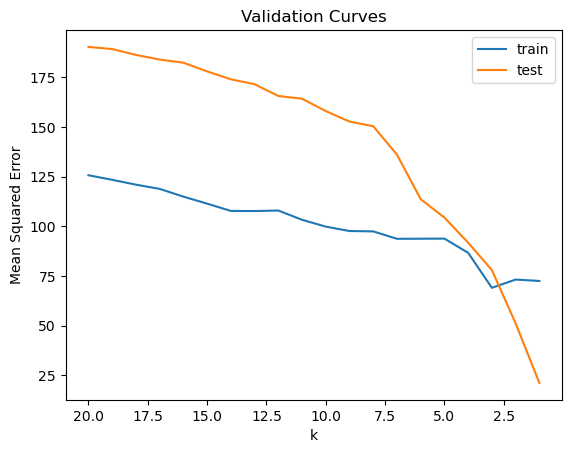

In [26]:
# Plotting
xvals = [i for i in range(1, 21)]
plt.plot(xvals, mean_mse_train, label="train")
plt.plot(xvals, mean_mse_test, label="test")
plt.legend()
plt.title("Validation Curves")
plt.gca().invert_xaxis()
plt.xlabel("k")
plt.ylabel("Mean Squared Error")
plt.show()

### Results of Validation Curves

From the validation curves, we can see that there is a slight inflection in the training set graph at around $k=3$. After this point, around $k = 8$ and above, the test set error is much higher than the training set error, which indicates overfitting. At the lower end, we have a different situation - both the test and training set errors are similar, and somewhat low (for $2 < k < 6$). This is the ideal zone for our hyperparameter, so we will choose the lowest error in this area, which is around $k = 3$.

## Problem 4: Generalization Error

Analyze and discuss the generalization error of your model with the value of k from Problem 3.

In [27]:
k, avg_mse = 3, 0
num_features = 8
folds = create_folds(data, 10)
for i in range(10):
    train, test = create_train_test(folds, i)
    yvals_train = [row[num_features] for row in train]
    yvals_test = [row[num_features] for row in test]
    
    knn_estimates = [knn(train, query, k, num_features) for query in test]
    knn_mse_test = mse(yvals_test, knn_estimates)
    print("Fold", i, "mean squared error:", knn_mse_test)
    avg_mse += knn_mse_test
avg_mse = avg_mse / 10
print("Mean:", avg_mse)

Fold 0 mean squared error: 69.05400442286945
Fold 1 mean squared error: 112.29218112189857
Fold 2 mean squared error: 65.12020064724922
Fold 3 mean squared error: 101.02163969795046
Fold 4 mean squared error: 51.947670981661275
Fold 5 mean squared error: 68.1319439050701
Fold 6 mean squared error: 70.55255749730313
Fold 7 mean squared error: 92.10108608414238
Fold 8 mean squared error: 65.18143128371091
Fold 9 mean squared error: 70.19067055016178
Mean: 76.55933861920174


### Results of Generalization

After tuning our hyperparameter to $k = 3$, we see that our generalization error drops by about 10 to a value of 77. This marked improvement further validates that our hyperparameter tuning was a success and improved our model. Going forward, we will use a value of $k = 3$.

## Q5: Choose your own adventure

You have three options for the next part:

1. You can implement mean normalization (also called "z-score standardization") of the *features*; do not normalize the target, y. See if this improves the generalization error of your model (middle).

2. You can implement *learning curves* to see if more data would likely improve your model (easiest).

3. You can implement *weighted* kNN and use the real valued GA to choose the weights. weighted kNN assigns a weight to each item in the Euclidean distance calculation. For two points, j and k:
$$\sqrt{\sum w_i (x^k_i - x^j_i)^2}$$

You can think of normal Euclidean distance as the case where $w_i = 1$ for all features  (ambitious, but fun...you need to start EARLY because it takes a really long time to run).

The easier the adventure the more correct it must be...

<a id="feature_scale"></a>
### feature_scale

`feature_scale` takes a set of data and a number of features and scales each feature by the below formula for Z-Score Standardization: $$x' = \frac{x - \bar{X}}{stdev(X)}$$

We take each value $x$ in the feature and we subtract the mean and divide by the standard deviation of the feature. The function then returns a new scaled data set. The `unscaled_data` comes in with rows as examples, so the data is transposed before applying mean normalization (so each row is a feature), and then transposed again at the end.

Feature scaling comes in many forms, and mean normalization is one of these forms. Alternatives include mean normalization, which divides by the range rather than the standard deviation, and unit-length scaling, which scales each feature by the length of the feature vector. All feature scaling methods seek to improve model performance by limiting the effect of large variability in any one feature on the final distance calculation. By scaling each feature by its relative spread, we ensure that the values of `x'` are much less variable than the originals, and therefore all features have equal weight on the final distance metric.

* **unscaled_data**: the set of data to be scaled, with each row as one feature
* **num_features**: the number of features to be scaled in `unscaled_data`

**returns** `List[List]`: the data set scaled with mean normalization, with rows as examples

In [28]:
def feature_scale(unscaled_data: List[List], num_features: int) -> List[List]:
    scaled_data = []
    new_data = list(map(list, zip(*unscaled_data)))
    for row in new_data[:num_features]:
        min_x, max_x = min(row), max(row)
        std_dev = stdev(row) if stdev(row) > 0 else 1
        mean_x = sum(row) / len(row)
        new_row = [(x - mean_x) / std_dev for x in row]
        scaled_data.append(new_row)
    if new_data: scaled_data.append(new_data[num_features])
    scaled_data = map(list, zip(*scaled_data))
    return list(scaled_data)

In [29]:
# assertions/unit tests
test_data = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
actual_scaled = feature_scale(test_data, 2)
assert actual_scaled[0][2] == 3

test_data = []
actual_scaled = feature_scale(test_data, 2)
assert actual_scaled == []

test_data = [[5, 4, 3], [5, 4, 3], [5, 4, 3], [5, 4, 3]]
actual_scaled = feature_scale(test_data, 2)
assert actual_scaled == [[0.0, 0.0, 3] for i in range(4)]

### Z-Score Standardization

To further improve our model, we can normalize the data using Z-Score Standardization. For each feature of the data, we can perform the transformation detailed above.
By normalizing values, we ensure that if there is a wide range of values for any one feature, that feature does not dominate the overall final distance calculation, which should increase the overall performance of our model.

In [30]:
# supporting code and discussion
avg_mse = 0
num_features = 8
k = 3
folds = create_folds(data, 10)
for i in range(10):
    train, test = create_train_test(folds, i)
    yvals_train = [row[num_features] for row in train]
    yvals_test = [row[num_features] for row in test]
    
    train = feature_scale(train, num_features)
    test = feature_scale(test, num_features)
    
    knn_estimates = [knn(train, query, k, num_features) for query in test]
    knn_mse_test = mse(yvals_test, knn_estimates)
    print("Fold", i, "mean squared error:", knn_mse_test)
    avg_mse += knn_mse_test
avg_mse = avg_mse / 10
print("Mean:", avg_mse)

Fold 0 mean squared error: 67.63188683926644
Fold 1 mean squared error: 119.81918306364615
Fold 2 mean squared error: 67.71787508090614
Fold 3 mean squared error: 103.75879838187706
Fold 4 mean squared error: 51.81019126213591
Fold 5 mean squared error: 77.55894250269688
Fold 6 mean squared error: 60.08533969795036
Fold 7 mean squared error: 69.55175134843581
Fold 8 mean squared error: 64.97058770226538
Fold 9 mean squared error: 69.57776483279396
Mean: 75.2482320711974


### Results of Z-Score Standardization

Although the impact of feature scaling is not large, there is still a slight decrease from the non-normalized model. The reason for a less noticeable impact might be that the data is largely clumped around the mean, meaning that the normalization does not change the values greatly. However, in other problems where the values of each feature might be more varied, mean normalization would have a larger impact on the overall performance of the model.

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.